In [15]:
# !pip install numpy
# !pip install trustregion
# !pip freeze


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from newton_tr_bounds import minimize

In [17]:
f= open("dgsol-1.3/data/data_set_1/graph.01.data", mode="r")
li = []
for line in f:
    li.append(line)

In [18]:
dico_constrains = {}
dico_interval = {}
list_relation = []
for elem in li:
    test = re.sub(r'\s+', ' ', elem).split(' ')
    print(test)
    i = int(test[1])-1
    j = int(test[2])-1
    mini = float(elem[21:42])
    maxi = float(elem[45:-1])
    dico_constrains[(i,j)] = (maxi + mini)/2
    dico_interval[(i,j)] = [mini, maxi]
    print(i, j, maxi, mini)
    list_relation.append((i,j))


['', '1', '2', '.2704259074127328E+01', '.2731438240195080E+01', '']
0 1 2.73143824019508 2.704259074127328
['', '1', '3', '.4472892845799014E+01', '.4517847672288210E+01', '']
0 2 4.51784767228821 4.472892845799014
['', '1', '4', '.4193622171822353E+01', '.4235770187344921E+01', '']
0 3 4.235770187344921 4.193622171822353
['', '1', '5', '.5678773711814897E+01', '.5735848248515641E+01', '']
0 4 5.735848248515641 5.678773711814897
['', '2', '3', '.2906097367604874E+01', '.2935305110205748E+01', '']
1 2 2.935305110205748 2.906097367604874
['', '2', '4', '.2404425382497866E+01', '.2428591068912180E+01', '']
1 3 2.42859106891218 2.404425382497866
['', '2', '5', '.4585412854912853E+01', '.4631498564179853E+01', '']
1 4 4.631498564179853 4.585412854912853
['', '2', '6', '.2215912974374222E+01', '.2238184016116640E+01', '']
1 5 2.23818401611664 2.215912974374222
['', '3', '4', '.1743909289498742E+01', '.1761436456418456E+01', '']
2 3 1.761436456418456 1.743909289498742
['', '3', '5', '.334462

In [19]:
#creation_of_the_problems_values
"""
    function that takes all our values and format it to make it usable for the algorithm
    We want P and X such that f(x,y,z) = h(P.T * X) = sum[i,j] {||p(i)-p(j)||**2 - C(i,j)} with C(i,j) contrainte de notre algo
"""
n_atomes = 63
X = (np.random.random(size=(n_atomes*3))-0.5)*3
print(X.shape)

def vector_creation(X, i):
    return np.array((X[i*3], X[i*3+1], X[i*3+2]))

def difference(X, i, j):
    x = vector_creation(X, i)
    y = vector_creation(X, j)
    return (x-y)

def norm(vector):
    return np.linalg.norm(vector)

def problem_function(X, relation, constraint):
    res = 0
    for i,j in relation:
        res += (norm(difference(X,i,j))**2 - constraint[i,j])**2
    return res

(189,)


In [20]:
def define_problem_function(lambda_k):
    """
        We have thanks to the paper: 
            <f>(λ, X) = <h>(sqrt(2λ), x(i) - x(j)) cf Th 4.1
            cf Th 4.2 too
        
    """

    def h(x, constraint):
        return (norm(x)**2 - constraint**2)**2

    def h_gauss_lambda(x, constraint, lambdak, p=3):
        result = h(x, constraint) + (3 + (p-1))* lambdak **2 * norm(x)**2 + .25*p*(p+2)*lambdak**4 - p*constraint**2*lambdak**2
        return result

    def f_gauss_λ(X, relation, constraint, lambda_k, h_g_l):
        res = 0
        for (i,j) in relation:
            cons_temp = constraint[i,j]
            x = difference(X, i, j)
            res += h_g_l(x, cons_temp, lambda_k)
        return res        

    def update_array(heussian, i, j, ddx, ddy, ddz):
        dd_list = [ddx, ddy, ddz]
        for A in [3*i, 3*j]:
            for B in [3*i, 3*j]:
                for a in range(3):
                    for b in range(3):
                        if a==b:
                            continue
                        to_add = 2 * dd_list[a] * dd_list[b]
                        heussian[A+a, B+b] += to_add
        return heussian

    def compute_grad_x_k(X, relation, constraint,lambda_k, n_atomes = n_atomes, p=3):
        grad = np.zeros((n_atomes*3))
        heussian_matrix = np.zeros((n_atomes*3, n_atomes * 3))
        for (i,j) in relation:
            # Do it for i and then for j
            # And in the order x, y, z
            grad_relation = 2*(norm(difference(X, i, j))**2 -  constraint[i,j]**2) + 2*(3 + (p-1)) * lambda_k**2 #cf 4.3 theorem

            #d/dx(i)
            ddx = 2 * (X[3*i] - X[3*j])
            grad[3*i] += grad_relation * ddx
            grad[3*j] += grad_relation * (-ddx)
            
            #d/dy(i)
            ddy = 2 * (X[3*i+1] - X[3*j+1])
            grad[3*i] += grad_relation * ddy
            grad[3*j] += grad_relation * (-ddy)

            #d/dz(i)
            ddz = 2 * (X[3*i+2] - X[3*j+2])
            grad[3*i] += grad_relation * ddz
            grad[3*j] += grad_relation * (-ddz)

            #Compute the heussian matrix d/(da(k))**2 for a € {x,y,z} and k {i,j}
            heussian_matrix[3*i  ,3*i  ] += 2 * grad_relation + 2 * ddx**2
            heussian_matrix[3*i+1,3*i+1] += 2 * grad_relation + 2 * ddy**2
            heussian_matrix[3*i+2,3*i+2] += 2 * grad_relation + 2 * ddz**2
            heussian_matrix[3*j  ,3*j  ] += 2 * grad_relation + 2 * ddx**2
            heussian_matrix[3*j+1,3*j+1] += 2 * grad_relation + 2 * ddy**2
            heussian_matrix[3*j+2,3*j+2] += 2 * grad_relation + 2 * ddz**2

            #Compute the heussian matrix on d/da(i)da(j)  for a € {x,y,z}
            heussian_matrix[3*i  ,3*j  ] -= 2 * grad_relation + 2 * ddx**2
            heussian_matrix[3*j  ,3*i  ] -= 2 * grad_relation + 2 * ddx**2

            heussian_matrix[3*i+1,3*j+1] -= 2 * grad_relation + 2 * ddy**2
            heussian_matrix[3*j+1,3*i+1] -= 2 * grad_relation + 2 * ddy**2

            heussian_matrix[3*i+2,3*j+2] -= 2 * grad_relation + 2 * ddz**2
            heussian_matrix[3*j+2,3*i+2] -= 2 * grad_relation + 2 * ddz**2            

            #Compute  the heussian matrix d/da(m)db(n) for a,b € {x,y,z} and n,m€ {i,j} tq a!=b
            heussian_matrix = update_array(heussian_matrix, i, j, ddx, ddy, ddz)
  
        return grad, heussian_matrix   

    return f_gauss_λ, h_gauss_lambda, compute_grad_x_k, update_array

In [21]:
def compute_quadratic_model_qk(grad_X_k, Heussian_matrix_X_k):
    """Cf section 4"""

    def function_quadratic(w):
        return (grad_X_k.T @ w + 0.5 * w.T @ Heussian_matrix_X_k @ w)
    
    def grad_quadratic_function(w):
        return grad_X_k + (Heussian_matrix_X_k + Heussian_matrix_X_k.T) @ w
    
    def heussian_f(w):
        return (Heussian_matrix_X_k + Heussian_matrix_X_k.T)
    
    return function_quadratic, grad_quadratic_function, heussian_f

In [22]:
def compute_scaling_matrix_Dk():
    """TODO but don't know"""
    return None

In [23]:
def compute_approximate_solution_sk(q_k, D_k, Delta_k, grad_q_k, Heussian_q_k):
    """find a min of qk(w) such that D_k * w <= Delta_k (Moré and Sorensen [18])"""

    return minimize(q_k, grad_q_k, Heussian_q_k, np.zeros((n_atomes * 3)), np.zeros((n_atomes * 3)), Delta_k)
    

In [24]:
def compute_ratio_rok(relation, constraint, X_k, sk, q_k):
    top = (problem_function(X_k + sk, relation, constraint) - problem_function(X_k, relation, constraint))
    bottom = q_k(sk)
    return top/bottom


In [25]:
def update_Delta_k():
    """TODO but don't know"""
    return np.ones((n_atomes * 3))

In [26]:

def find_minimizer_x(relation, constraint):

    X_k = X.copy()

    lambda_0 = 100 #TODO
    maxiter = 20000 #TODO
    Delta_k = update_Delta_k()
    nu0 = 0.1 #TODO

    for k in range(maxiter):
        lambda_k = (1-k/maxiter) * lambda_0
        f_gauss_λ, h_gauss_lambda, compute_grad_x_k, update_array = define_problem_function(lambda_k) #DONE
        gradient_X_k, Heussian_matrix_X_k = compute_grad_x_k(X_k, relation, constraint,lambda_k) #OK
        q_k, grad_q_k, Heussian_q_k = compute_quadratic_model_qk(gradient_X_k, Heussian_matrix_X_k) #DONE
        D_k = compute_scaling_matrix_Dk() #OK
        sk, _ = compute_approximate_solution_sk(q_k, D_k, Delta_k, grad_q_k, Heussian_q_k) #DONE
        rok = compute_ratio_rok(relation, constraint, X_k, sk, q_k)
        if rok >= nu0:
            X_k = X_k + sk
        else:
            Delta_k = update_Delta_k()
    return X_k


In [27]:
# X_k = X.copy()

# lambda_0 = 100 #TODO
# maxiter = 20000 #TODO
# Delta_k = update_Delta_k()
# nu0 = 0.1 #TODO

# for k in range(maxiter):
# lambda_k = (1-k/maxiter) * lambda_0
# f_gauss_λ, h_gauss_lambda, compute_grad_x_k, update_array = define_problem_function(lambda_k) #DONE
# gradient_X_k, Heussian_matrix_X_k = compute_grad_x_k(X_k, list_relation, dico_constrains,lambda_k) #OK
# q_k, grad_q_k, Heussian_q_k = compute_quadratic_model_qk(gradient_X_k, Heussian_matrix_X_k) #DONE

# test = q_k(np.ones(n_atomes * 3))
# print("test.shape:", test)

In [28]:
X_s = find_minimizer_x(list_relation, dico_constrains)

/home/perce/code/tp_IA302/newton_tr_bounds.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  rhok = (fk - f(xk + sk)) / (fk - model_value)


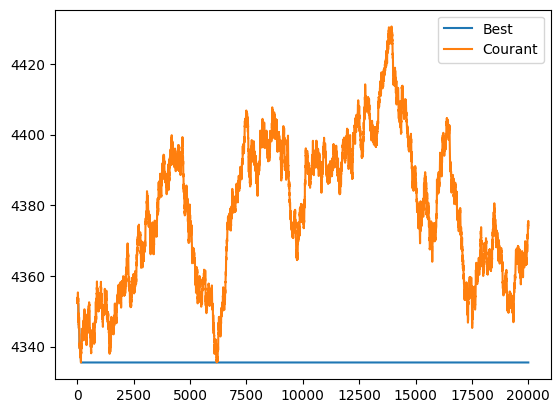

In [ ]:
plt.figure()
plt.plot(bestseq)
plt.plot(costseq)
plt.legend(["Best", "Courant"])

In [ ]:
li = []
for (i,j), constrain in dico_constrains.items():
    li.append(np.abs((np.linalg.norm(best[i]-best[j])**2 - constrain**2)))

In [ ]:
fini(best,dico_interval,i)

False

In [ ]:
best[0]-best[2]

array([ 0.60356441,  1.08368839, -0.5017777 ])

In [ ]:
dico_constrains

{(0, 2): 0.022477413244597955,
 (0, 4): 0.028537268350371736,
 (1, 3): 0.012082843207156913,
 (1, 5): 0.011135520871208948,
 (2, 4): 0.01680759687044442,
 (2, 16): 0.01183240995045498,
 (2, 18): 0.014560391487096425,
 (3, 4): 0.011697065684143526,
 (3, 16): 0.013546650431311091,
 (4, 17): 0.01705975090848133,
 (4, 43): 0.01139577977481565,
 (5, 7): 0.017555175299526438,
 (5, 16): 0.013888939761074415,
 (6, 8): 0.020388321837549572,
 (7, 8): 0.012573134143536446,
 (7, 11): 0.013937230940239465,
 (8, 12): 0.016344632263898484,
 (8, 15): 0.014755340326057409,
 (9, 10): 0.014008637734303164,
 (10, 18): 0.016569762041047875,
 (10, 21): 0.012473777093371385,
 (11, 13): 0.013222603602937921,
 (13, 14): 0.014055631047469541,
 (13, 16): 0.011245376229420012,
 (13, 18): 0.012889181641164038,
 (14, 16): 0.015170329713504405,
 (14, 33): 0.016927763848447963,
 (15, 16): 0.008901710850220512,
 (16, 17): 0.008898681346848014,
 (18, 19): 0.013946684655210984,
 (18, 21): 0.011927547180726528,
 (18, 23)

In [ ]:
best[0]

array([-0.2734512 ,  1.24789969,  0.56466721])

In [ ]:
best

array([[-2.73451200e-01,  1.24789969e+00,  5.64667205e-01],
       [ 4.87533855e-01,  1.40971823e+00,  3.28616126e-01],
       [-8.77015614e-01,  1.64211294e-01,  1.06644490e+00],
       [-1.39751121e-01,  6.39135708e-01, -1.11793633e+00],
       [ 9.36482378e-01,  1.36373789e-01, -1.25175864e+00],
       [-2.62902638e-01,  6.44588611e-01, -6.66643430e-01],
       [ 1.79951617e-01, -7.96760328e-01,  7.41324042e-01],
       [ 3.85714219e-01,  1.22572874e+00, -9.52724418e-01],
       [ 1.42317708e+00,  1.27498899e+00,  7.71490001e-01],
       [-3.89176789e-01, -1.43047728e+00, -2.19042825e-01],
       [ 1.47622713e+00, -3.65863903e-01,  5.80481923e-01],
       [ 1.37204280e-01, -7.35535969e-01,  2.39970983e-01],
       [ 1.16488689e+00,  6.37987684e-01,  1.19881607e+00],
       [-7.37504641e-01,  8.93813814e-01, -1.13031779e+00],
       [ 1.04573642e+00, -1.35570943e+00,  1.27727902e-01],
       [-1.27599307e+00,  8.40651720e-01, -1.16966478e+00],
       [-1.46991621e+00,  3.49204652e-01

(0, 2)
1.3380774982180144 4.472892845799014 4.51784767228821 False
(0, 4)
2.4492513035117494 5.678773711814897 5.735848248515641 False
(1, 3)
1.7549352889172307 2.404425382497866 2.42859106891218 False
(1, 5)
1.4625730254257305 2.215912974374222 2.23818401611664 False
(2, 4)
2.9434023805753764 3.344627737133087 3.378242930873976 False
(2, 16)
2.0807007697358166 2.354590416611769 2.378255236512679 False
(2, 18)
1.5808456656302488 2.897445102154656 2.926565885128849 False
(3, 4)
1.1953896873278897 2.327657584353851 2.351051715722138 False
(3, 16)
1.3757970938561968 2.695715700885392 2.722809001748014 False
(4, 17)
1.2225035473627917 3.394805129900685 3.428924631717648 False
(4, 43)
2.857139983520938 2.267703194864796 2.290494754414427 False
(5, 7)
0.9166624267149062 3.493392106534848 3.528502457133901 False
(5, 16)
1.268076119245033 2.763829566018859 2.791607445541008 False
(6, 8)
2.4163329238098132 4.057174101514501 4.0979507451896 False
(7, 8)
2.0128763330255515 2.501990827321312 2.527

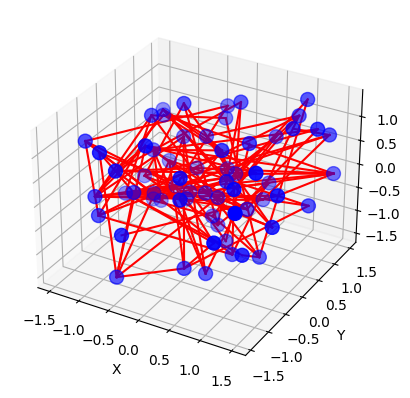

In [ ]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates
x, y, z = best.T

# Plot the atoms
ax.scatter(x, y, z, c='b', marker='o', s=100)

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot the lines between connected atoms
for link in dico_constrains:
    print(link)
    x_link, y_link, z_link = best[list(link)].T
    mini, maxi = dico_interval[link]

    color = (mini < ((x_link[0] - x_link[1])**2 + (y_link[0] - y_link[1])**2 + (z_link[0] - z_link[1])**2)**.5 < maxi )
    print(((x_link[0] - x_link[1])**2 + (y_link[0] - y_link[1])**2 + (z_link[0] - z_link[1])**2)**.5, mini, maxi, color)
    if color:
        ax.plot(x_link, y_link, z_link, c='g')
    else:
        ax.plot(x_link, y_link, z_link, c='r')



# Show the 3D plot
plt.show()